# LSTM Remaining Useful Life (RUL) Model Pipeline
This notebook builds a complete pipeline for training an LSTM model on the CMAPSS FD003 dataset.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('train_FD003.csv')
df.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [ ]:
# Compute RUL
max_cycle = df.groupby('unit')['cycle'].max().reset_index().rename(columns={'cycle': 'max_cycle'})
max_cycle
#df = df.merge(max_cycle, on='unit', how='left')

#df['RUL'] = df['max_cycle'] - df['cycle']
#df[['unit','cycle','RUL']].head()


,unit,max_cycle
0,1,259
1,2,253
2,3,222
3,4,272
4,5,213
...,...,...
95,96,491
96,97,275
97,98,307
98,99,145


In [ ]:
# Feature selection
exclude = {'unit','cycle','RUL','max_cycle'}
feature_cols = [c for c in df.columns if c not in exclude]
features = df[feature_cols].values
labels = df['RUL'].values

# Scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)
scaled_df['RUL'] = labels
scaled_df['unit'] = df['unit']
scaled_df['cycle'] = df['cycle']
scaled_df.head()

,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL,unit,cycle
0,0.470930,0.769231,0.0,0.0,0.355972,0.370523,0.308580,0.0,1.0,0.208812,...,0.647755,0.0,0.272727,0.0,0.0,0.559524,0.446331,258,1,1
1,0.546512,0.230769,0.0,0.0,0.388759,0.399100,0.309360,0.0,1.0,0.236590,...,0.685659,0.0,0.363636,0.0,0.0,0.488095,0.534836,257,1,2
2,0.418605,0.307692,0.0,0.0,0.313817,0.353298,0.445398,0.0,1.0,0.230843,...,0.564462,0.0,0.272727,0.0,0.0,0.404762,0.458577,256,1,3
3,0.383721,0.538462,0.0,0.0,0.487119,0.417107,0.237285,0.0,1.0,0.268199,...,0.558909,0.0,0.363636,0.0,0.0,0.470238,0.391966,255,1,4
4,0.593023,0.461538,0.0,0.0,0.196721,0.476218,0.321217,0.0,1.0,0.245690,...,0.556736,0.0,0.363636,0.0,0.0,0.577381,0.543371,254,1,5


In [ ]:
# Sequence building
TIME_STEPS = 50
X_list, y_list = [], []
for uid, group in scaled_df.groupby('unit'):
    g = group[feature_cols + ['RUL']].values
    if len(g) >= TIME_STEPS:
        for i in range(len(g) - TIME_STEPS + 1):
            X_list.append(g[i:i+TIME_STEPS, :-1])  # sensors
            y_list.append(g[i+TIME_STEPS-1, -1])   # RUL at end

X = np.array(X_list)
y = np.array(y_list)
X.shape, y.shape

((19820, 50, 24), (19820,))

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((15856, 50, 24), (3964, 50, 24))

In [ ]:
# Build LSTM model
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(loss='mse', optimizer=Adam(1e-3), metrics=['mae'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,289 (141.75 KB)

 Trainable params: 36,289 (141.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
248/248 - 20s - 81ms/step - loss: 14898.2500 - mae: 89.4352 - val_loss: 8950.6416 - val_mae: 68.1818
Epoch 2/8
248/248 - 20s - 80ms/step - loss: 8388.2373 - mae: 69.5461 - val_loss: 8005.8496 - val_mae: 69.0879
Epoch 3/8
248/248 - 17s - 68ms/step - loss: 8243.0264 - mae: 70.3523 - val_loss: 8005.8076 - val_mae: 69.0795
Epoch 4/8
248/248 - 20s - 79ms/step - loss: 8230.1318 - mae: 70.3811 - val_loss: 8005.6782 - val_mae: 68.9879
Epoch 5/8
248/248 - 16s - 66ms/step - loss: 8259.5010 - mae: 70.5118 - val_loss: 8007.1216 - val_mae: 69.2385
Epoch 6/8
248/248 - 18s - 71ms/step - loss: 7400.2563 - mae: 64.2810 - val_loss: 4142.4722 - val_mae: 39.2458
Epoch 7/8
248/248 - 16s - 65ms/step - loss: 3518.1106 - mae: 40.3067 - val_loss: 2822.4976 - val_mae: 36.3278
Epoch 8/8
248/248 - 16s - 65ms/step - loss: 2848.3376 - mae: 36.4370 - val_loss: 2275.9351 - val_mae: 32.3094


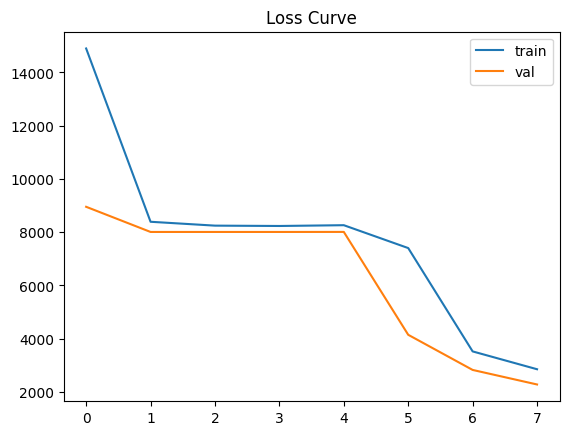

In [ ]:
# Train
history = model.fit(X_train, y_train, epochs=8, batch_size=64,
                    validation_data=(X_test, y_test), verbose=2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Loss Curve')
plt.show()

In [ ]:
# Prediction Pairs
# 	If predicted RUL ≈ true RUL, the model is accurate.
# 	•	If predicted > true, the model is too optimistic (thinks engine lasts longer).
# 	•	If predicted < true, it is too conservative.
#  In practice, a ±10 cycle error is normal for FD001 because sensor noise is real.

# preds_int = preds.astype(int)
# list(zip(y_test[:20], preds_int))

# Get predictions
preds = model.predict(X_test[:200]).flatten()

# Convert predictions to normal Python integers
preds_int = [int(round(p)) for p in preds]
# Convert true y_test values to normal Python integers
true_int = [int(round(float(v))) for v in y_test[:200]]

# Combine into clean pairs
pairs = list(zip(true_int, preds_int))

pairs[:10]

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[(13, 8),
 (183, 206),
 (97, 133),
 (37, 40),
 (148, 118),
 (109, 151),
 (15, 12),
 (19, 21),
 (10, 5),
 (55, 44)]

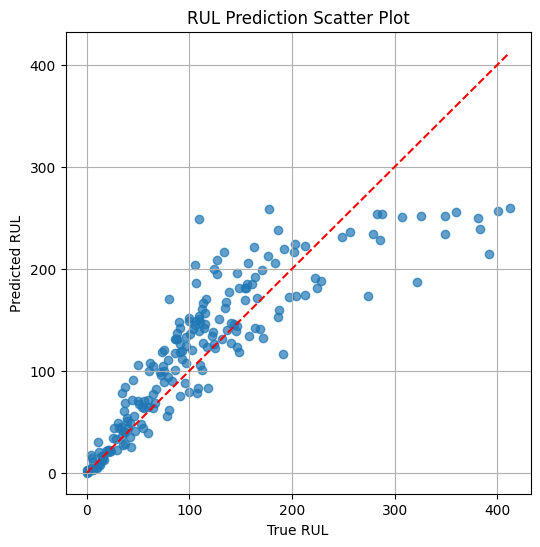

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(true_int, preds_int, alpha=0.7)
plt.plot([0, max(true_int)], [0, max(true_int)], 'r--')  # ideal line

plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("RUL Prediction Scatter Plot")
plt.grid(True)
plt.show()

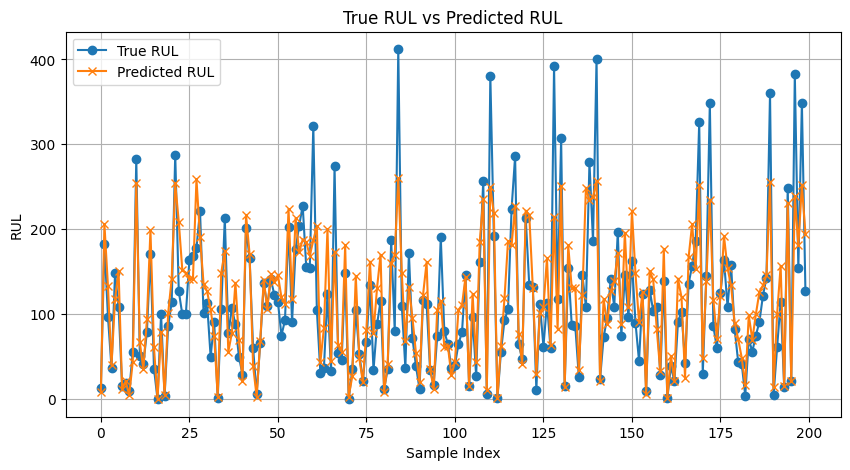

In [ ]:
# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    "True_RUL": true_int,
    "Pred_RUL": preds_int
})

plt.figure(figsize=(10,5))
plt.plot(df_plot["True_RUL"].values, label="True RUL", marker='o')
plt.plot(df_plot["Pred_RUL"].values, label="Predicted RUL", marker='x')

plt.title("True RUL vs Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# -------- 7. evaluate --------
# Typical MAE for FD001 using a basic LSTM:
# 	•	MAE < 20 → Excellent
# 	•	MAE 20–30 → Good
# 	•	MAE 30–50 → Acceptable
# 	•	MAE > 50 → Poor model performance
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, pred)
rmse = math.sqrt(mean_squared_error(y_test, pred))
print(f"Test MAE: {mae:.3f}, RMSE: {rmse:.3f}")

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Test MAE: 32.309, RMSE: 47.707


# Section 2: Feature Importance Analysis

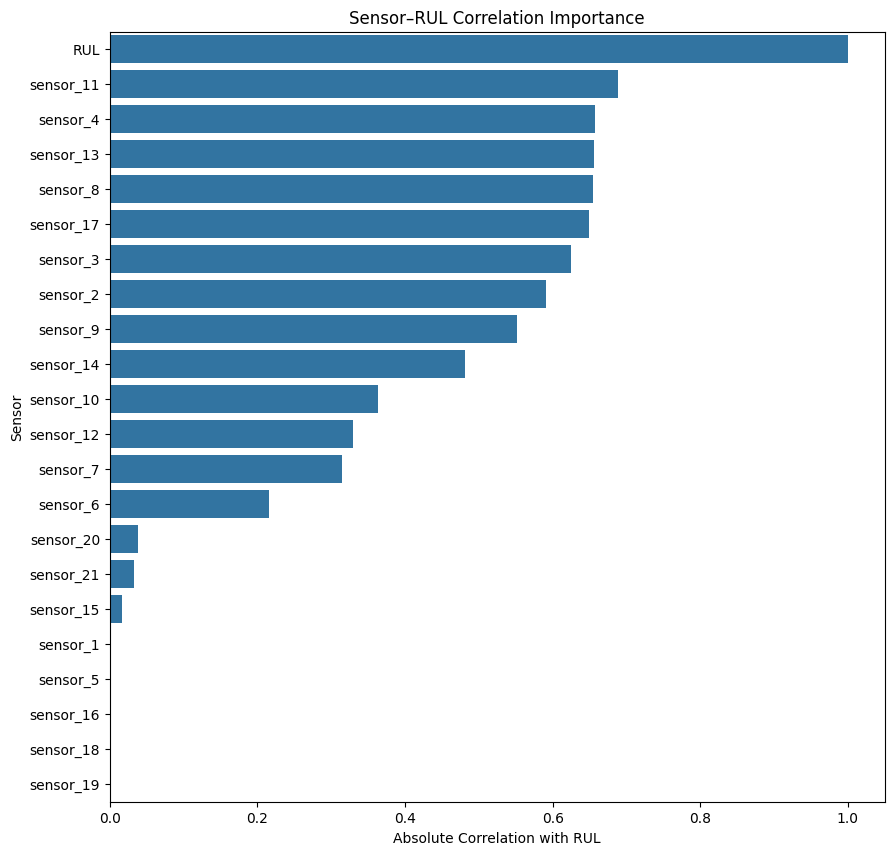

RUL          1.000000
sensor_11    0.688915
sensor_4     0.657224
sensor_13    0.656340
sensor_8     0.655345
sensor_17    0.649220
sensor_3     0.624236
sensor_2     0.590564
sensor_9     0.551843
sensor_14    0.481807
sensor_10    0.363432
sensor_12    0.329452
sensor_7     0.315048
sensor_6     0.215352
sensor_20    0.037782
sensor_21    0.033465
sensor_15    0.016501
sensor_1          NaN
sensor_5          NaN
sensor_16         NaN
sensor_18         NaN
sensor_19         NaN
Name: RUL, dtype: float64


In [ ]:
# #1 Correlation with RUL (Fast Diagnostic)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sensor_cols = [c for c in df.columns if "sensor" in c]

corrs = df[sensor_cols + ["RUL"]].corr()["RUL"].abs().sort_values(ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x=corrs.values, y=corrs.index)
plt.title("Sensor–RUL Correlation Importance")
plt.xlabel("Absolute Correlation with RUL")
plt.ylabel("Sensor")
plt.show()

print(corrs)

In [ ]:
#1 Correlation with RUL (Fast Diagnostic)
corr = df.corr()['RUL'].abs().sort_values(ascending=False)
corr.head(15)

,RUL
RUL,1.000000
sensor_11,0.688915
sensor_4,0.657224
sensor_13,0.656340
sensor_8,0.655345
sensor_17,0.649220
sensor_3,0.624236
sensor_2,0.590564
sensor_9,0.551843
cycle,0.482744


In [ ]:
# 2: Time Series Stability / Degradation Analysis

# Some sensors don’t change at all (flat line) → useless
# Some sensors vary but not related to failure → noise
# Some sensors show consistent degradation → extremely important

# Identify sensors with clear downward or upward trends

import numpy as np

slopes = {}

for s in sensor_cols:
    slopes[s] = np.polyfit(df["cycle"], df[s], 1)[0]

pd.Series(slopes).sort_values()

	# •	Large negative slope = strong degradation
	# •	Large positive slope = increasing stress/temp etc → can also be important
	# •	Values near zero = poor signal

,0
sensor_15,-2.452339e-04
sensor_6,-7.671656e-05
sensor_18,-4.879357e-15
sensor_1,-9.797946e-16
sensor_16,2.158100e-20
sensor_5,7.112149e-18
sensor_19,3.512050e-16
sensor_10,1.862245e-05
sensor_21,4.695620e-04
sensor_13,6.999501e-04


In [ ]:
# 3. Permutation Importance
import numpy as np
from sklearn.metrics import mean_absolute_error

def permutation_importance_lstm(model, X_val, y_val, feature_names):
    baseline_pred = model.predict(X_val)
    baseline_mae = mean_absolute_error(y_val, baseline_pred)

    importance = {}

    for i, name in enumerate(feature_names):
        X_shuffled = X_val.copy()

        # shuffle only one feature across all time steps
        X_shuffled[:,:,i] = np.random.permutation(X_shuffled[:,:,i].flatten()).reshape(X_val[:,:,i].shape)

        pred = model.predict(X_shuffled)
        mae = mean_absolute_error(y_val, pred)
        importance[name] = mae - baseline_mae

    return sorted(importance.items(), key=lambda x: x[1], reverse=True)



important_sensors = permutation_importance_lstm(model, X_test, y_test, feature_cols)
important_sensors[:10]

124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18

[('sensor_11', 6.672285708203148),
 ('sensor_4', 4.574086394946647),
 ('sensor_17', 4.182224485177386),
 ('sensor_3', 2.5701745662887134),
 ('sensor_2', 2.523311769587906),
 ('sensor_9', 2.098447789871308),
 ('sensor_14', 1.0493170914553147),
 ('sensor_12', 0.9950899244723104),
 ('sensor_8', 0.9019021895515849),
 ('sensor_7', 0.8441543704806662)]

In [ ]:
#4.PCA / Health Indicator Contribution
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(df[feature_cols])

importance = pd.Series(np.abs(pca.components_[0]), index=feature_cols)
importance.sort_values(ascending=False).head(10)

,0
sensor_9,0.747324
sensor_14,0.605383
sensor_4,0.201066
sensor_3,0.146329
sensor_7,0.077198
sensor_12,0.074629
sensor_17,0.038589
sensor_2,0.009096
sensor_11,0.006475
sensor_8,0.003597


In [ ]:
key_sensors = ["sensor_9", "sensor_17", "sensor_8", "sensor_12", "sensor_11", "sensor_7", "sensor_3", "sensor_4", "sensor_14", "sensor_2"]

In [ ]:
#
weights = {
    'sensor_9':	0.747324,
'sensor_14':	0.605383,
'sensor_4':	0.201066,
'sensor_3':	0.146329,
'sensor_7':	0.077198,
'sensor_12':	0.074629,
'sensor_17':	0.038589,
'sensor_2':	0.009096,
'sensor_11':0.006475,
'sensor_8':0.003597
}

df["CDI_weighted"] = sum(df[s] * w for s, w in weights.items())

In [ ]:
df_norm = (df[key_sensors] - df[key_sensors].min()) / (df[key_sensors].max() - df[key_sensors].min())
df["HI_norm"] = df_norm.mean(axis=1)
df_norm

,sensor_9,sensor_17,sensor_8,sensor_12,sensor_11,sensor_7,sensor_3,sensor_4,sensor_14,sensor_2
0,0.204233,0.272727,0.623529,0.231279,0.348571,0.208812,0.370523,0.308580,0.239116,0.355972
1,0.202431,0.363636,0.647059,0.236882,0.308571,0.236590,0.399100,0.309360,0.278567,0.388759
2,0.241484,0.272727,0.664706,0.217015,0.302857,0.230843,0.353298,0.445398,0.264526,0.313817
3,0.215326,0.363636,0.647059,0.240448,0.314286,0.268199,0.417107,0.237285,0.245612,0.487119
4,0.268799,0.363636,0.670588,0.245033,0.262857,0.245690,0.476218,0.321217,0.252109,0.196721
...,...,...,...,...,...,...,...,...,...,...
24715,0.244211,0.545455,0.794118,0.096281,0.902857,0.107759,0.620669,0.734009,0.201184,0.688525
24716,0.215464,0.636364,0.782353,0.109017,0.822857,0.107759,0.627912,0.812480,0.234086,0.573770
24717,0.210149,0.727273,0.794118,0.085074,0.851429,0.080939,0.787434,0.847894,0.190025,0.702576
24718,0.204465,0.636364,0.800000,0.114111,0.777143,0.051724,0.651008,0.772387,0.217740,0.725995


In [ ]:
# PCA-Based Health Index
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df[key_sensors]

# Standardize (PCA works best on standardized data)
scaler_hi = StandardScaler()
X_scaled = scaler_hi.fit_transform(X)

# PCA
pca = PCA(n_components=1)
df["HI_pca"] = pca.fit_transform(X_scaled)

df["HI_pca"]

,HI_pca
0,-1.382925
1,-0.847900
2,-0.934665
3,-0.725349
4,-0.931427
...,...
24715,2.953248
24716,2.879356
24717,3.702880
24718,3.016384


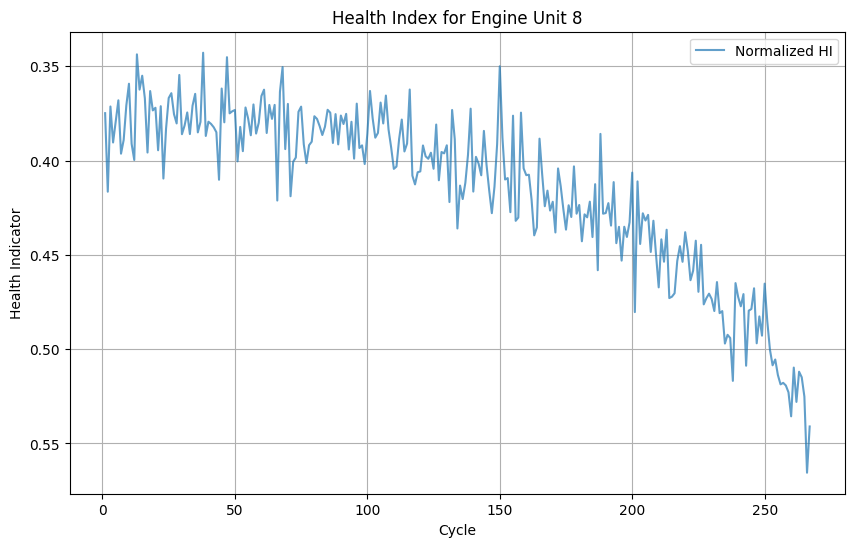

In [ ]:
import matplotlib.pyplot as plt

unit_id = 8
g = df[df["unit"] == unit_id]

plt.figure(figsize=(10,6))
#plt.plot(g["cycle"], g["HI_pca"], label="PCA Health Index")
#plt.plot(g["cycle"], g["CDI_weighted"], label="Weighted CDI", alpha=0.7)
plt.plot(g["cycle"], g["HI_norm"], label="Normalized HI", alpha=0.7)

plt.gca().invert_yaxis()        # health decreases over time
plt.title(f"Health Index for Engine Unit {unit_id}")
plt.xlabel("Cycle")
plt.ylabel("Health Indicator")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Add FFT indicators for these sensors

# compute FFT energy and FFT peak amplitude over a rolling window
#	•	For sensors: sensor_9, sensor_14, sensor_4, sensor_3, sensor_17
#	•	Add new columns like sensor_9_fft_energy, sensor_9_fft_peak, etc.


In [ ]:
import numpy as np

def fft_energy(x):
    """
    Sum of squared magnitudes of the FFT (a simple measure of signal power).
    x is a 1D numpy array (rolling window of one sensor).
    """
    # real FFT (only non-negative frequencies)
    f = np.fft.rfft(x)
    mag = np.abs(f)
    return float(np.sum(mag ** 2))

def fft_peak(x):
    """
    Maximum magnitude in the FFT spectrum (dominant amplitude).
    """
    f = np.fft.rfft(x)
    mag = np.abs(f)
    return float(np.max(mag))

In [ ]:
# Important sensors (from your feature importance results)
fft_sensors = ["sensor_9", "sensor_17", "sensor_8", "sensor_12", "sensor_11", "sensor_7", "sensor_3", "sensor_4", "sensor_14", "sensor_2"]

# Rolling window (in cycles) for FFT computation
FFT_WINDOW = 50  # you can try 30, 50, 100 etc.

In [ ]:
# We'll compute FFT features per engine (unit) over a rolling window
for col in fft_sensors:
    energy_col = f"{col}_fft_energy"
    peak_col   = f"{col}_fft_peak"

    # Rolling by engine unit
    df[energy_col] = (
        df.groupby("unit")[col]
          .rolling(window=FFT_WINDOW, min_periods=FFT_WINDOW)
          .apply(fft_energy, raw=True)
          .reset_index(level=0, drop=True)
    )

    df[peak_col] = (
        df.groupby("unit")[col]
          .rolling(window=FFT_WINDOW, min_periods=FFT_WINDOW)
          .apply(fft_peak, raw=True)
          .reset_index(level=0, drop=True)
    )

# Optional: check new columns
#df[[ "unit", "cycle" ] + [s + "_fft_energy" for s in fft_sensors]].head(60)

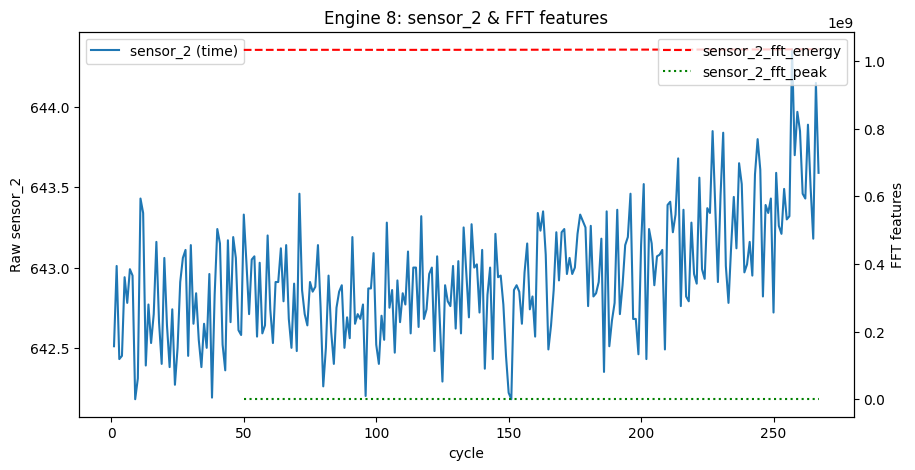

In [ ]:
unit_id = 8  # choose any engine ID that exists in your data
plot_cols = ["sensor_2", "sensor_2_fft_energy", "sensor_2_fft_peak"]

tmp = df[df["unit"] == unit_id].reset_index(drop=True)

ax = tmp.plot(x="cycle", y="sensor_2", label="sensor_2 (time)", figsize=(10,5))
ax2 = ax.twinx()
tmp.plot(x="cycle", y="sensor_2_fft_energy", label="sensor_2_fft_energy", ax=ax2, style='r--')
tmp.plot(x="cycle", y="sensor_2_fft_peak", label="sensor_2_fft_peak", ax=ax2, style='g:')

ax.set_ylabel("Raw sensor_2")
ax2.set_ylabel("FFT features")
ax.set_title(f"Engine {unit_id}: sensor_2 & FFT features")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")